# Lab Session 6: Climate data and xarray

* **Statistics 159/259, Spring 2022**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* 03/10/2022

Menu for today:

1. **Introduction to xarray.** We will be usign xarry to manipulate climate data. 

1. **Working with ERA 5 data.** As an example, we are going to practice data manipulation and visualization with xarray using a different climate dataset. 

Useful links: 
- Introduction to xArray (lecture notes)
- [ERA5 Dataset](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)

**Acknowledgment:** Large part of the contents in this notebook were done by [Dr. Chelle Gentemann](https://cgentemann.github.io).

In [1]:
# Run this cell to set up your notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import xarray as xr

#import os
from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

/tmp/ipykernel_837/1977167424.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


We will work with the global ERA5 dataset.

In [2]:
DATA_DIR = Path.home()/Path('shared/climate-data')

monthly_2deg_path = DATA_DIR / "era5_monthly_2deg_aws_v20210920.nc"

ds = xr.open_dataset(monthly_2deg_path)

EXPLORATION

### Question 1

Plot the average temperature as a function of the latitude:

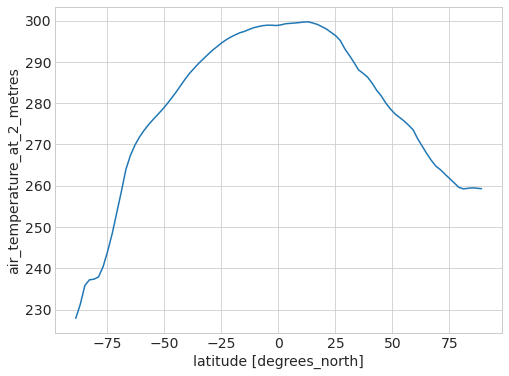

In [19]:
# BEGIN SOLUTION
ds.mean(("longitude", "time")).air_temperature_at_2_metres.plot()
# END SOLUTION

### Question 2

Plot the yearly average temperature. That is, time series where the x-axis are the years and the y-axis is the averaged yearly temperature over all latitude and longitudes. Repeat this analysis separately for borh south and north hemispheres. 

Remember to weight the averages by longitude!!! We did this in class using the weigthed mean:

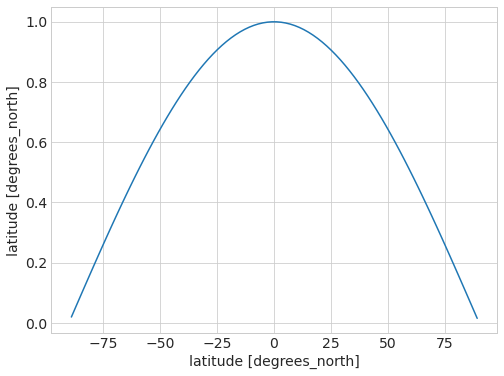

In [20]:
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
weights.plot();

In [22]:
ds_weighted = ds.weighted(weights)
ds_weighted

DatasetWeighted with weights along dimensions: latitude

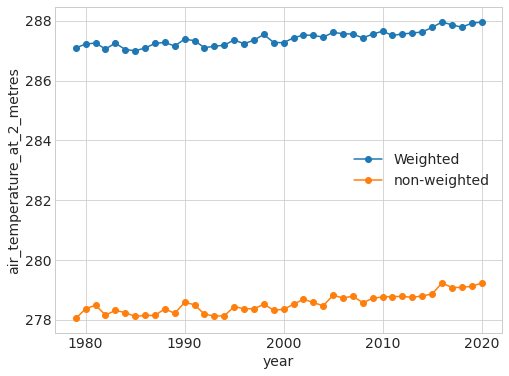

In [23]:
# BEGIN SOLUTION
ds_weighted.mean(("latitude", "longitude")).groupby(ds.time.dt.year).mean().air_temperature_at_2_metres.plot(marker='o', label="Weighted")
ds.groupby(ds.time.dt.year).mean().mean(("latitude", "longitude")).air_temperature_at_2_metres.plot(marker='o', label="non-weighted")
plt.legend()
# END SOLUTION

## 2. Exploring Snow with ERA 5

Now, we turn our attention to other questions - ERA5 a very rich and interesting dataset, and the lecture only scratched its surfac!

We are going today to focus on just one more bit: we'll take a look at the snow accumulation data for the northern and southern hemispheres.

But you should see this as an invitation to keep learning from these data! Think of looking at other variables in the dataset. Is there annual cycle? trend? Some of the data might look very different than the air temperature - eg. precipitation which is either 0 or +. Can you use PDFs to look at changes in distributions over a region? at a point? Or talk about the data a little & what you understand it is measuring? Are any of the data variables related to each other? Can you plot correlations between data?

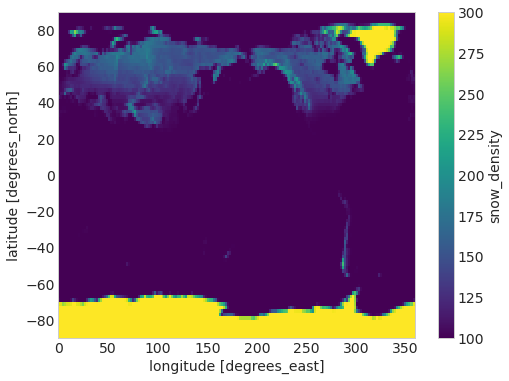

In [24]:
mean_map = ds.mean("time")  # takes the mean across all variables in ds
mean_map.snow_density.plot();

What are the units of this? Where can you find that information?

In [26]:
snow = ds.snow_density

### Question 3

Let's look at the snow across the globe in February and August, which are roughly the peaks of the summer/winter seasons.

Recreate the following figure, along with a corresponding one for August 1980:

<img src="figures/snow-distribution-1980-02.png" width="500px" />

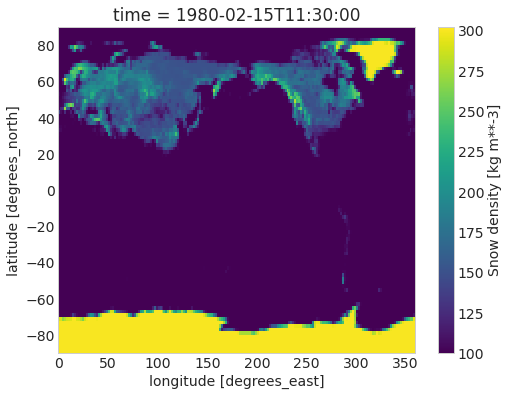

In [27]:
# BEGIN SOLUTION
snow.sel(time='1980-02').plot();
# END SOLUTION

### Question 4

Let's now find the peaks in the northern and southern hemispheres. Plot a time series of density of ice coverage for both the north and south hemisphere. 

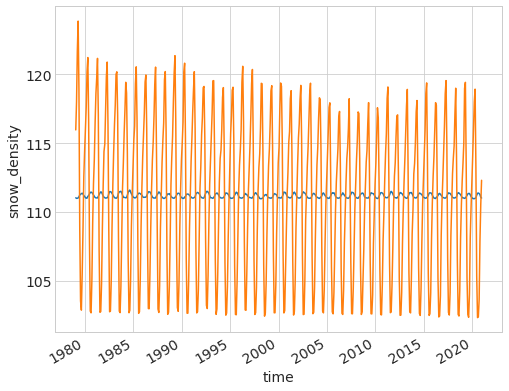

In [28]:
# BEGIN SOLUTION

ds_south = ds.sel(latitude=slice(-90,0))
ds_north = ds.sel(latitude=slice(0,90))

weights_south = np.cos(np.deg2rad(ds_south.latitude))
weights_north = np.cos(np.deg2rad(ds_north.latitude))

ds_south_weigthed = ds_south.weighted(weights_south)
ds_north_weigthed = ds_north.weighted(weights_north)

#t_snow_south = snow.sel(latitude=slice(-90,0)).mean(('latitude', 'longitude')) # this is without weights
t_snow_south = ds_south_weigthed.mean(("latitude", "longitude")).snow_density
t_snow_south.plot();

#t_snow_north = snow.sel(latitude=slice(0,90)).mean(('latitude', 'longitude'))  # this is without weigths
t_snow_north = ds_north_weigthed.mean(("latitude", "longitude")).snow_density
t_snow_north.plot();
# END SOLUTION

### Question 5

Let's look for example at what the cycle in the northern hemisphere looks like for the year 1979. You need to replicate this figure:

<img src="figures/snow-cycle-1979.png" width="500px" />

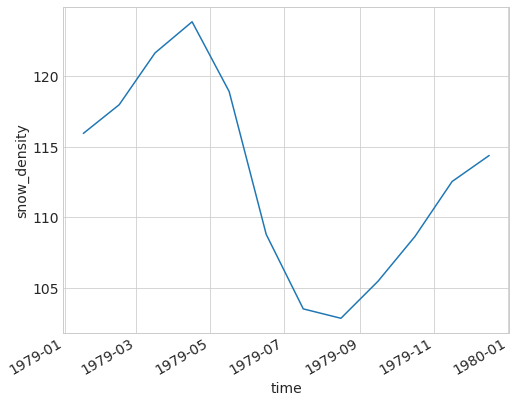

In [30]:
# BEGIN SOLUTION
t_snow_north.isel(time=t_snow_north.time.dt.year==1979).plot();
# END SOLUTION

### Question 6

And finally, we're going to find the peaks for the maximum and minimum snow accumulation in both hemispheres, and study when those peaks happen, how much snow there is, and whether the amounto of total snow is going up or down.

You'll need to recreate a dataframe like the one pictured here (only a few rows shown, and this is for the northern hemisphere, you'll make one for each hemisphere):

<img src="figures/snow-peaks-north-df.png" width="900px" />

**Hint:** look up the documentation for the xarray `idxmax` method.

**Hint:**
1. First, we want to extract the years from the data and iterate over them (try using `range`).
1. When iterating over the years, we want to first pick the designated year, then find the days with the most and least snow as well as the amount of snow on those days.
1. Once we've found the days, assign `vals` to be an array of the information we've calculated.
1. Finally, append all the necessary information to `peaks`.

- Amplitude is `max - min`
- You may want to use `x.values.item` to extract information from the datetime objects.

In [32]:
def extract_peaks(snow_data):
    # BEGIN SOLUTION
    yy = snow_data.time.dt.year
    min_y, max_y = yy.min().values.item(), yy.max().values.item()
    # END SOLUTION
    years = range(min_y, max_y + 1) # SOLUTION
    peaks = []
    for y in years:
    # BEGIN SOLUTION
        snow_year = snow_data.isel(time = snow_data.time.dt.year == y)
        min_d, max_d = snow_year.idxmin(), snow_year.idxmax()
        min_v, max_v = snow_year.sel(time = min_d), snow_year.sel(time = max_d)
        min_day, max_day = min_d.dt.dayofyear, max_d.dt.dayofyear
    # END SOLUTION
        vals = [x.values.item() for x in [min_day, max_day, min_v, max_v, (max_v-min_v)]] # SOLUTION
    # BEGIN SOLUTION
        peaks.append([y, min_d.values, max_d.values] + vals)
    # END SOLUTION

    snow_peaks = pd.DataFrame(peaks, 
                              columns = ['year', 'min_date', 'max_date',
                                         'min_dayofyear', 'max_dayofyear',
                                         'min_snow', 'max_snow', 'amplitude'])

    return snow_peaks

peaks_north = extract_peaks(t_snow_north)

With this data, we can now quickly explore several questions. For example, during what day of the year do the min and max happen?

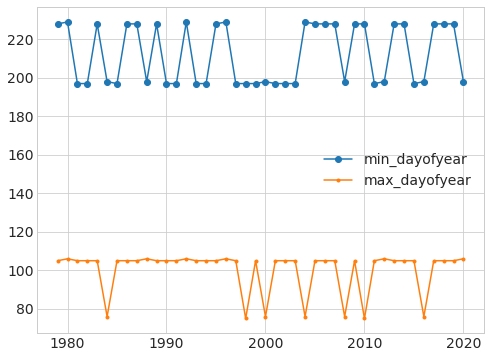

In [33]:
plt.plot('year', 'min_dayofyear', 'o-', data=peaks_north);
plt.plot('year', 'max_dayofyear', '.-', data=peaks_north);
plt.legend();

What is the min and max amount of snow at those times?

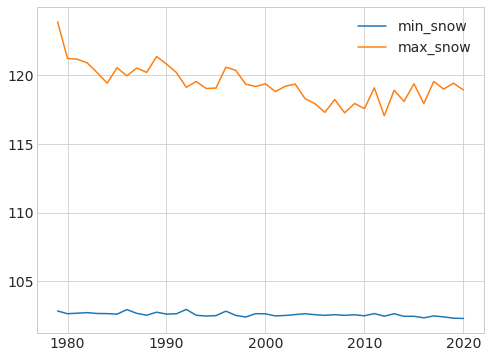

In [34]:
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'max_snow', data=peaks_north);
plt.legend();

Given the difference in scales, it's a bit easier to see what is happening if we plot the min and max separately:

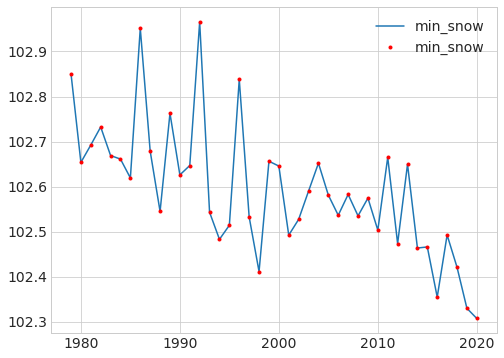

In [35]:
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'min_snow', 'r.', data=peaks_north);
plt.legend();

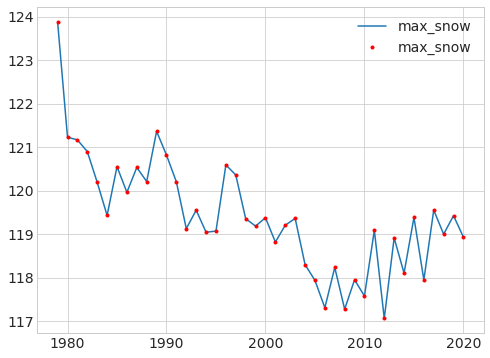

In [36]:
plt.plot('year', 'max_snow', data=peaks_north);
plt.plot('year', 'max_snow', 'r.', data=peaks_north);
plt.legend();

What do you think this is telling us about the ice in the northern hemisphere? What are the main sources of ice there, and what is happening to them?

The above figures are for the northern hemisphere. Repeat them for the southern one. What do you observe? Any differences?

I hope this lab has taught you some useful skills regarding tools like xarray and data with a different structure than data frames. But more importantly, that it has shown you how the ideas from this course also apply to problems as critical to humanity as climate change, and that you have the foundations on which to better understand these questions.

Don't stop here! This dataset is fascinating, and both the lecture and the lab were barely an appetizer!